<a href="https://colab.research.google.com/github/mahendra-gehlot/CP260/blob/main/CP260_Lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lab 4: Experiments with Particle Filter

a) Write the code for the function sir() which implements the sample importance resampling

b) experiment with different number of particles and plot the error of the particle based approximation as a function of number of particles **(Results are added in last cell of this notebook)**

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt



In [ ]:
def move (
      v, 
      w,
      x,
      y,
      theta,
      rng_r,
      rng_l,
      rng_t,
      tstep = 1,
      WHEELBASE = 1,
      SLIPPARAM = 10,
      ANGSTDDEV=0.0157,
      addNoise = True,
  ):
    '''
    Function: Implement noisy motion for a two wheeled robot. Noise happens due to wheel slippages
    Inputs: 
        2D pose (x,y, theta) at the beginning of time step
        velocity (linear and angular) 
    Parameters:
        Three random number generators: one for each wheel slippage and one for angular noise
        Wheele base width, power law parameter for slippage and std dev for angular noise
        addNoise: if True - adds motion noise using the random number generators
    Outputs:
        2D Pose (xn,yn, thetan) after applying the velocities and noise
    
    '''

    #calculate the desired velocities of the left and right wheel
    vl = v - 0.5*WHEELBASE*w
    vr = v + 0.5*WHEELBASE*w

    #sample left and right wheel slippage
    #from power law distribution
    #modeling probablity no slip: mostly no slip - occasional slip as as per 
    #pdf of power law pdf(x) a*x^(a-1) for x in [0,1] and a >= 1
    sr = rng_r.power(SLIPPARAM)
    sl = rng_l.power(SLIPPARAM)
    #model angular noise a gaussian
    nt = rng_t.normal(0,ANGSTDDEV)

    #incorporate the wheel slippage to get actual wheel linear velocities which will be smaller
    if addNoise :
        vla = vl*sl
        vra = vr*sr
    else:
        vla = vl
        vra = vr

    #regenerate the noise velocities
    vn = (vla+vra)/2
    wn = (vra-vla)/WHEELBASE
    phi = math.copysign(1,vn)*wn * tstep

    #update the pose after the timestep
    if ( abs(wn)>0.0):  #has some rotation
      R = abs(vn)/wn
      xn = x - R*math.sin(theta) + R*math.sin(theta+phi)
      yn = y + R*math.cos(theta) - R*math.cos(theta+phi)
      thetan = theta + phi

    else:  #no rotation
      xn = x + (vla+vra)*0.5*tstep*math.cos(theta)
      yn = y + (vla+vra)*0.5*tstep*math.sin(theta)

    #now add the extra noise to angle
    if addNoise: 
        thetan = theta + nt 

    #keep theta within +- math.pi
    if ( thetan >= math.pi):
      thetan = thetan-2*math.pi
    if (thetan <= -math.pi):
      thetan = 2*math.pi -theta

    return xn,yn,thetan


def sMove (
      v,
      w,
      xEst,
      yEst,
      thetaEst,
      rngEst_r,
      rngEst_l,
      rngEst_t,
      tstep=1,
      WHEELBASE=1,
      velStdErr=0.1,
      angStdErr=math.pi*0.01,
  ) :
    
    '''
    Function: Sample motion model. Assume two wheeled robot 
    Inputs: 
        2D pose (x,y,theta)
        velocity (linear and angular)
    Parameters:
        random number generators for each wheel and angular velocity
        wheel base
        std deviations for the random noise
    Outputs:
        sampled 2D pose from the distribution
        
    Assumption: 
        wheel velocity noise is gaussian and independent
        Could be different noise model from actual
    '''
    vl = v - 0.5*WHEELBASE*w
    vr = v + 0.5*WHEELBASE*w

    #sample left and right wheel slippage
    #from power law distribution
    vra = rngEst_r.normal(vr,velStdErr)
    vla = rngEst_l.normal(vl,velStdErr)
    #model angular noise a gaussian
    nt = rngEst_t.normal(0,angStdErr)

    #regenerate the noise velocities
    vn = (vla+vra)/2
    wn = (vra-vla)/WHEELBASE
    phi = math.copysign(1,vn)*wn * tstep


    #update the pose after the timestep
    #if ( abs(vla-vra)>0.01*min(abs(vla),abs(vra))):  #has some rotation
    if ( abs(wn)>0):  #has some rotation
      R = abs(vn)/wn
      xn = xEst - R*math.sin(thetaEst) + R*math.sin(thetaEst+phi)
      yn = yEst + R*math.cos(thetaEst) - R*math.cos(thetaEst+phi)
      thetan = thetaEst + phi
    else:  #no rotation
      xn = xEst + (vla+vra)*0.5*tstep*math.cos(thetaEst)
      yn = yEst + (vla+vra)*0.5*tstep*math.sin(thetaEst)
      thetan = thetaEst

    #now add the extra noise to angle
    thetan = thetan + nt 

    #keep theta within +- math.pi
    if ( thetan >= math.pi):
      thetan = thetan-2*math.pi
    if (thetan <= -math.pi):
      thetan = 2*math.pi - thetan

    return xn, yn, thetan


def pltS (pp,tp,t):
    #scatter plot of the error in particle poses w.r.t true pose at time t
    plt.scatter(pp[:,t,0]-tp[t,0],pp[:,t,1]-tp[t,1],facecolor='red')
    plt.show()



In [ ]:
# Your Code here
def sir (
    pp,
    plkl_a,
):
  ''' 
  Function: Sample Importance Resampling
  Inputs: 
      Vector of particles
      Vector of particle Log Likelihoods
  Outputs:
      Vector of resampled particles (new array)
      Vector for new log likelihoods for the resampled particles
  '''
  NPARTICLES = pp.shape[0]
  npp = np.zeros((NPARTICLES,NSTEPS,3)) #particles for pose estimate

  plkl_a = plkl_a - np.max(plkl_a)
  particleWt = np.exp(plkl_a)
  particleWt = particleWt/np.sum(particleWt)

  r = np.random.random()*1.0/NPARTICLES
  c = particleWt[0]
  i1 = 0
  for m in range(NPARTICLES):
    U = r + ((m-1)/NPARTICLES)
    while U > c:
      i1 = i1 + 1
      c = c + particleWt[i1]
    npp[m] = pp[i1]
    plkl_a[m] = plkl_a[i1]



  #your code here

  return npp, plkl_a

In [ ]:
#check if particle filter based pose estimation is able to track true pose

NSTEPS = 30              #number of time steps for simulation
NP = 50

tp = np.zeros((NSTEPS,3))     #True pose with time
pp = np.zeros((NP,NSTEPS,3))  #Particles for pose
ep = np.zeros((NP,NSTEPS,3))  #Particle pose errors
mp = np.zeros((NSTEPS,3))     #measured pose

plkl = np.zeros((NP,NSTEPS)) #log likelihood per step
plkl_a = np.zeros(NP)        #accumulated likelihood per particle

#initialize the random number generators
rng_l = np.random.default_rng(1)     #for left wheel noise
rng_r = np.random.default_rng(2)     #for right wheel noise
rng_t = np.random.default_rng(3)     #for angle noise
rngEst_l = np.random.default_rng(4)  #noise in left wheel in sample motion model
rngEst_r = np.random.default_rng(5)  #noise of right wheel in sample motion model
rngEst_t = np.random.default_rng(6)  #noise in angle for sample motion model
rng_m = np.random.default_rng(7)     #for measurement noise of pose
#%%      


tp[0] = [0,0,0]

for i in range(1,NSTEPS):
    #Velocity commands
    v = np.random.normal(10, 0.1)
    w = np.random.normal(0.2,0.01)
    
    #move the rat to next position
    tp[i] = move(v,w,tp[i-1,0],tp[i-1,1],tp[i-1,2],rng_r, rng_l, rng_t, SLIPPARAM=5,ANGSTDDEV=0.01, addNoise=False)
    #tp[i] = move(1.0,0.1,tp[i-1,0],tp[i-1,1],tp[i-1,2],rng_r, rng_l, rng_t, SLIPPARAM=5,ANGSTDDEV=0.01, addNoise=False)

    mp[i] = tp[i] + rng_m.multivariate_normal([0,0,0], [[0.01,0,0],[0,0.01,0],[0,0,0.001]])
    
    for j in range(NP):
        #move each particle
        pp[j][i] = sMove(v,w,pp[j][i-1,0],pp[j][i-1,1],pp[j][i-1,2],rngEst_r,rngEst_l,rngEst_t, WHEELBASE=1.1, velStdErr = 2,angStdErr=0.5) #with motion model

        #error in pose for j-th particle - use this as log likelihood
        ep[j][i] = pp[j][i] - mp[i]   
        plkl[j][i] = -np.sum((ep[j][i])**2)
        plkl_a[j] += plkl[j][i] #likelihood for this particle (accumulated over its trajectory).
    #end for j

    #sample importance resample
    pp,plkl_a = sir(pp, plkl_a)
    #plkl_a.fill(0)    

#end for i

#convert log likelihood to probabilities
#subtract the largest log likelihood
pWt = np.exp(plkl_a- np.max(plkl_a))
pWt = pWt/np.sum(pWt)


In [ ]:
#find particle with maximum llkelihood
mle = np.argmax(plkl_a)
#find the average particle
#average particle
pAve = np.average(pp,0,pWt)

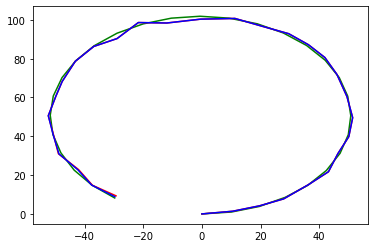

In [ ]:
fig,ax = plt.subplots()
ax.plot(tp[:,0],tp[:,1],"green")
ax.plot(pp[mle,:,0],pp[mle,:,1],"red")
ax.plot(pAve[:,0],pAve[:,1],"blue")
#ax.plot(pp[mle-1,:,0],pp[mle-1,:,1],"blue")

plt.show()

**The Result are shown (Number of particles vs estimation plots)**



Number of Particles = 5

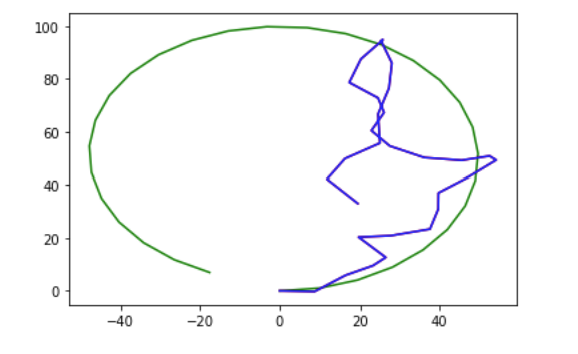




Number of Particle = 10 

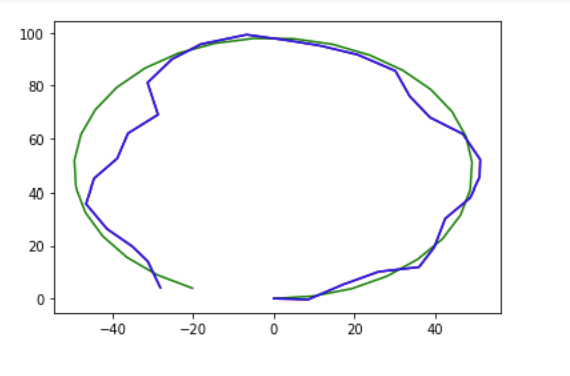

Number of particle = 20

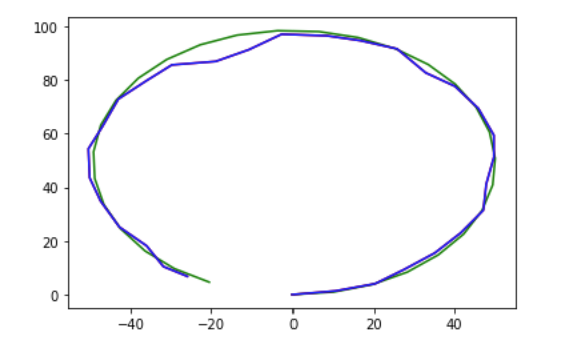

Number of Particle = 50

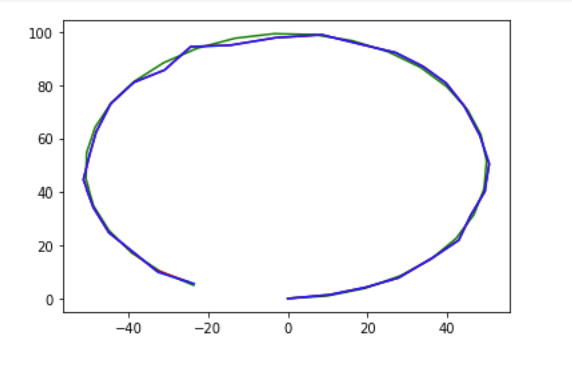

As we can see, Higher number of particles make it as good measurement or better estimation of motion.